# Richardson-Lucy example

The following demonstrates the process to deconvolve and image using Richardson-Lucy deconvolution following the conventions of Leist et al. 2024 (https://ui.adsabs.harvard.edu/abs/2024AJ....167...96L/abstract). The procedure is as follows:

    (1) Import the original and PSF data
    (2) Richardson-Lucy deconvolve the data
    (3) measure merit functions (FWHM, aperture flux, smoothness) as a function of deconvolution iteration
    (4) save the merits, merit plot, converged FITS files, and plot a comparison between the original and nth-deconvolved image.

In [67]:
# import the necessary functions
from Convenience_Functions import *

In [68]:
# Set the data you want to save by setting the following variables to either True (to save)
# or False (to ignore).
# Display an example of how the S-index and Radial profiles are measured after 25 iterations?
plot_rad_S = True
# write the merit functions results to a .txt file
save_merits = True
# Save a plot of the merit functions versus deconvolution iteraion
save_plot_merits = True
# Save the original and final converged images to a FITS file, updating the FITS header with the merit 
# function results
save_final_FITS = True
# Save a plot of a side-by-side comparison between the original and nth-deconvolved image
save_plot_comparison = True

In [69]:
# set the global parameters
# JWST/MIRI filter used
filter = 'F2100W'
# skip any initial iterations?
# NOTE: for Kraken LSE and AMRL deconvolution the first two iterations are skipped as these images are a  oise estimate and the original image
skip = 0
# set the total number of deconvolution iterations
dec_iter = 100
# set the data import/export path
path = 'test_data/'

In [70]:
# import data (model + PSF)the test data (toy AGN model and reference PSF)
# Set the FITS file names
img_name = filter + '_toy_AGN_model.fits'
psf_name = filter + '_detectors_sampled_WebbPSF.fits'

# read in the original image data
image = get_pkg_data_filename(path + img_name)
image_list = fits.open(image)
# save the header info
sci_hdr = image_list[0].header
# save the image data
image_data = image_list[0].data

# read in the PSF data
psf = get_pkg_data_filename(path + psf_name)
psf_list = fits.open(psf)
# save the image data
psf_data = psf_list[0].data

# sanity check: print the image array shapes to make sure the data imported correctly
print('Image data shape (y,x): ', image_data.shape, 
      '\nPSF data shape (y,x): ', psf_data.shape
     )

Image data shape (y,x):  (256, 256) 
PSF data shape (y,x):  (256, 256)


0  iterations:  
centroid (y,x):		 [127.15415381 127.1783905 ]  
FWHM ("):		 0.90643  
Δ_total (%):		 0.00000  
Δ_between (%):		 0.00000  
Aperture flux (Jy):	 0.26762  
Δ_total (%):		 0.00000  
Δ_between (%):		 0.00000  
S-index:		 0.02305  
stddev (σ):		0.00000  
Δ_total (%):		 0.00000  
Δ_between (%):		 0.00000

 1  iterations:  
centroid (y,x):		 [127.68175563 127.67534162]  
FWHM ("):		 0.79963  
Δ_total (%):		 11.78216  
Δ_between (%):		 11.78216  
Aperture flux (Jy):	 0.29767  
Δ_total (%):		 11.22805  
Δ_between (%):		 11.22805  
S-index:		 0.02373  
stddev (σ):		0.00000  
Δ_total (%):		 2.94684  
Δ_between (%):		 2.94684

 2  iterations:  
centroid (y,x):		 [127.75339509 127.75506134]  
FWHM ("):		 0.74137  
Δ_total (%):		 18.20970  
Δ_between (%):		 7.28598  
Aperture flux (Jy):	 0.30373  
Δ_total (%):		 13.49459  
Δ_between (%):		 2.03774  
S-index:		 0.02433  
stddev (σ):		0.00034  
Δ_total (%):		 5.53042  
Δ_between (%):		 2.50963

 3  iterations:  
centroid (y,x):		 [127.

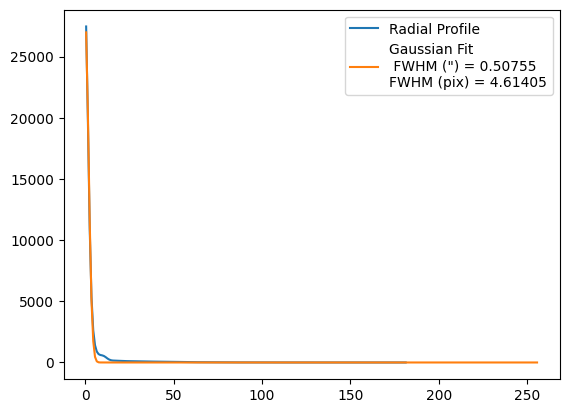

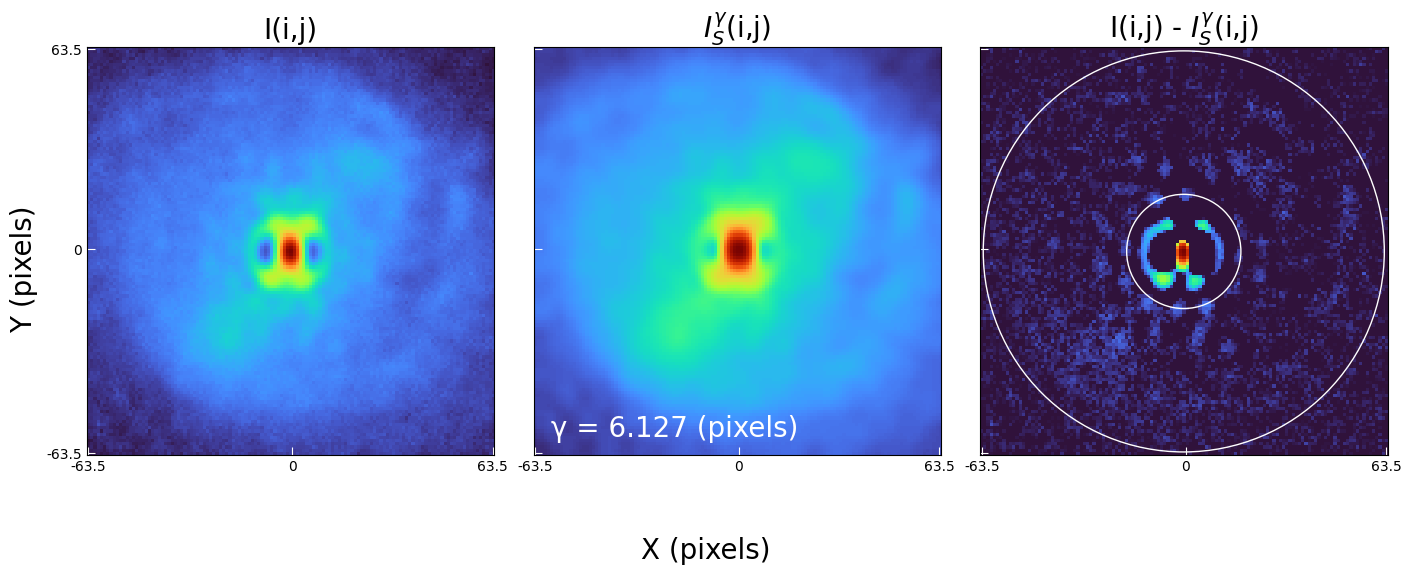


 25  iterations:  
centroid (y,x):		 [127.88233216 127.87107848]  
FWHM ("):		 0.50755  
Δ_total (%):		 44.00616  
Δ_between (%):		 0.52372  
Aperture flux (Jy):	 0.30392  
Δ_total (%):		 13.56510  
Δ_between (%):		 0.00273  
S-index:		 0.02836  
stddev (σ):		0.00134  
Δ_total (%):		 23.02726  
Δ_between (%):		 0.51485

 26  iterations:  
centroid (y,x):		 [127.88258751 127.87140731]  
FWHM ("):		 0.50503  
Δ_total (%):		 44.28344  
Δ_between (%):		 0.49520  
Aperture flux (Jy):	 0.30391  
Δ_total (%):		 13.56213  
Δ_between (%):		 0.00261  
S-index:		 0.02851  
stddev (σ):		0.00137  
Δ_total (%):		 23.66033  
Δ_between (%):		 0.51457

 27  iterations:  
centroid (y,x):		 [127.88281614 127.87171388]  
FWHM ("):		 0.50266  
Δ_total (%):		 44.54475  
Δ_between (%):		 0.46899  
Aperture flux (Jy):	 0.30390  
Δ_total (%):		 13.55930  
Δ_between (%):		 0.00249  
S-index:		 0.02865  
stddev (σ):		0.00140  
Δ_total (%):		 24.29340  
Δ_between (%):		 0.51194

 28  iterations:  
centroid (y,x)

In [71]:
warnings.filterwarnings('ignore')

# RL deconvolve the data (measure merit functions and save the final FITS cube)
#build arrays to save everything
# image results
image_arr = []
final_fits = []

# full deconvolution results
iter = []
ffwhm = []
delta_B_fwhm = []
delta_T_fwhm = []
fflux = []
delta_B_flux = []
delta_T_flux = []
s_param = []
delta_B_S = []
delta_T_S = []
std_dev = []

# delta index values
idx_fwhm = []
idx_flux = []
idx_S = []

# set the stopping criteria
stop = False
# NOTE: for Kraken LSE and AMRL the 1st iteration is a noise estimate image, the 2nd image is the original observation,
# start iterations at index 2
for j in range(0, dec_iter):
    if j == 0:
        # this is the original image, measure merit functions
        dec_data = image_data

        # The following param is for the Smoothness parameter (set once and hold fixed), set the radius for the boxcar filter size
        # (smoothness parameter) equal to the filter PSF diffraction limit
        # MIRI PSFS diffraction limits (in pixels): F560W (1.882), F1000W (2.982), F1500W (4.436), F1800W (5.373), F2100W (6.127)
        # source: https://jwst-docs.stsci.edu/jwst-mid-infrared-instrument/miri-performance/miri-point-spread-functions
        smooth_radius = 6.127

        # Compute the image centroid
        # NOTE: assumed to be the brightest pixel in the image array
        imy1, imx1 = np.unravel_index(np.argmax(dec_data, axis=None), dec_data.shape)

        # find the encircled energy of 99% of the flux of the original image
        # NOTE: sets the outer radius for the smoothness parameter
        cog = COG(dec_data, (imy1, imx1), max_level=99, params=False)
        boxsize = cog[0]

        # guess the centroid position based on the image peak
        im_y, im_x = np.unravel_index(np.argmax(dec_data, axis=None), dec_data.shape)
        # determine the centroid from a quadratic fit using the image peak as the initial guess
        xycent = centroid_quadratic(dec_data, xpeak=im_y, ypeak=im_x, fit_boxsize=15)

        # measure merit functions
        fwhm, flux, S, centroid = measure_merits(dec_data, 17.8, boxsize, smooth_radius, xycent, convert=True,sanity_check=False, plot=False)

        # save the initial fwhm, flux, and S values as variables
        initial_fwhm = fwhm
        initial_flux = flux
        initial_S = S

        # save the initial fwhm, flux, and S values to an array
        idx_fwhm.append(fwhm)
        idx_flux.append(flux)
        idx_S.append(S)

        # NOTE: to keep the .txt outputs consistent for index = 0 append a blank space in the delta measurements
        delta_fwhm_total = 0.0
        delta_fwhm_between = 0.0
        delta_flux_total = 0.0
        delta_flux_between = 0.0
        delta_S_total = 0.0
        delta_S_between = 0.0
        stddev = 0

        # print the initial results
        print(j - skip, ' iterations: ',
                '\ncentroid (y,x):\t\t', centroid,
                ' \nFWHM ("):\t\t', '%.5f' % fwhm,
                ' \nΔ_total (%):\t\t', '%.5f' % delta_fwhm_total,
                ' \nΔ_between (%):\t\t', '%.5f' % delta_fwhm_between,
                ' \nAperture flux (Jy):\t', '%.5f' % flux,
                ' \nΔ_total (%):\t\t', '%.5f' % delta_flux_total,
                ' \nΔ_between (%):\t\t', '%.5f' % delta_flux_between,
                ' \nS-index:\t\t', '%.5f' % S,
                ' \nstddev (σ):\t\t''%.5f' % stddev,
                ' \nΔ_total (%):\t\t', '%.5f' % delta_S_total,
                ' \nΔ_between (%):\t\t', '%.5f' % delta_S_between,
                )

    else:
        # Richardson-Lucy deconvolve the data
        # Imports are: (1) original image, (2) PSF image, (3) number of iterations
        dec_data = richardson_lucy_np(image_data, psf_data, j)

        # guess the centroid position based on the image peak
        im_y, im_x = np.unravel_index(np.argmax(dec_data, axis=None), dec_data.shape)
        # determine the centroid from a quadratic fit using the image peak as the initial guess
        xycent = centroid_quadratic(dec_data, xpeak=im_y, ypeak=im_x, fit_boxsize=15)

        # measure merit functions
        if plot_rad_S:
            if j == 25:
                # NOTE: this code can be easily removed, this was only included to give an example of how the Radial profile and S-index is measured
                fwhm, flux, S, centroid = measure_merits(dec_data, 17.8, boxsize, smooth_radius, xycent, convert=True,sanity_check=False, plot=True)
            else:
                fwhm, flux, S, centroid = measure_merits(dec_data, 17.8, boxsize, smooth_radius, xycent, convert=True,sanity_check=False, plot=False)
        else:
            fwhm, flux, S, centroid = measure_merits(dec_data, 17.8, boxsize, smooth_radius, xycent, convert=True,sanity_check=False, plot=False)
        
        # measure Δ
        # FWHM
        delta_fwhm_total = calculate_difference(initial_fwhm, fwhm)
        delta_fwhm_between = calculate_difference(idx_fwhm[j - skip], fwhm)
        # flux
        delta_flux_total = calculate_difference(initial_flux, flux)
        delta_flux_between = calculate_difference(idx_flux[j - skip], flux)
        # S
        delta_S_total = calculate_difference(initial_S, S)
        delta_S_between = calculate_difference(idx_S[j - skip], S)
        stddev = np.std(s_param[:j])

        # FWHM LIMIT MET
        # Save the FITS file and the final merit data if the flux criteria is met before the FWHM criteria
        if delta_fwhm_between < 0.1:
            if stop != True:
                stop = True
                print('\n ##################################### FWHM limit reached- iteration: ', j-skip,'#####################################')
                print('\n', j - skip, ' iterations: ',
                        '\ncentroid (y,x):\t\t', centroid,
                        ' \nFWHM ("):\t\t', '%.5f' % fwhm,
                        ' \nΔ_total (%):\t\t', '%.5f' % delta_fwhm_total,
                        ' \nΔ_between (%):\t\t', '%.5f' % delta_fwhm_between,
                        ' \nAperture flux (Jy):\t', '%.5f' % flux,
                        ' \nΔ_total (%):\t\t', '%.5f' % delta_flux_total,
                        ' \nΔ_between (%):\t\t', '%.5f' % delta_flux_between,
                        ' \nS-index:\t\t', '%.5f' % S,
                        ' \nstddev (σ):\t\t''%.5f' % stddev,
                        ' \nΔ_total (%):\t\t', '%.5f' % delta_S_total,
                        ' \nΔ_between (%):\t\t', '%.5f' % delta_S_between,
                        )
                print('\n######################################################################################################################\n')

                # append all the information and update the FITS header
                final_fits.append(dec_data)
                final_iter = j-skip
                final_fwhm = '%.5f' % fwhm
                final_flux = '%.5f' % flux
                final_S = '%.5f' % S
                sci_hdr['CONVCRT'] = ('FWHM', 'Criteria Criteria image converged to')

            else:
                print('\n', j - skip, ' iterations: ',
                        '\ncentroid (y,x):\t\t', centroid,
                        ' \nFWHM ("):\t\t', '%.5f' % fwhm,
                        ' \nΔ_total (%):\t\t', '%.5f' % delta_fwhm_total,
                        ' \nΔ_between (%):\t\t', '%.5f' % delta_fwhm_between,
                        ' \nAperture flux (Jy):\t', '%.5f' % flux,
                        ' \nΔ_total (%):\t\t', '%.5f' % delta_flux_total,
                        ' \nΔ_between (%):\t\t', '%.5f' % delta_flux_between,
                        ' \nS-index:\t\t', '%.5f' % S,
                        ' \nstddev (σ):\t\t''%.5f' % stddev,
                        ' \nΔ_total (%):\t\t', '%.5f' % delta_S_total,
                        ' \nΔ_between (%):\t\t', '%.5f' % delta_S_between,
                        )
        
        # FLUX LIMIT MET
        # Save the FITS file and the final merit data if the flux criteria is met before the FWHM criteria
        elif delta_flux_total > 30:
            # check if criteria is met
            if stop != True:
                stop = True
                print('\n ##################################### Flux limit reached- iteration: ', j - skip, '#####################################')
                print('\n', j - skip, ' iterations: ',
                        '\ncentroid (y,x):\t\t', centroid,
                        ' \nFWHM ("):\t\t', '%.5f' % fwhm,
                        ' \nΔ_total (%):\t\t', '%.5f' % delta_fwhm_total,
                        ' \nΔ_between (%):\t\t', '%.5f' % delta_fwhm_between,
                        ' \nAperture flux (Jy):\t', '%.5f' % flux,
                        ' \nΔ_total (%):\t\t', '%.5f' % delta_flux_total,
                        ' \nΔ_between (%):\t\t', '%.5f' % delta_flux_between,
                        ' \nS-index:\t\t', '%.5f' % S,
                        ' \nstddev (σ):\t\t''%.5f' % stddev,
                        ' \nΔ_total (%):\t\t', '%.5f' % delta_S_total,
                        ' \nΔ_between (%):\t\t', '%.5f' % delta_S_between,
                        )
                print(
                    '\n######################################################################################################################\n')

                # append all the information and update the FITS header
                final_fits.append(dec_data)
                final_iter = j - skip
                final_fwhm = '%.5f' % fwhm
                final_flux = '%.5f' % flux
                final_S = '%.5f' % S
                sci_hdr['CONVCRT'] = ('FWHM', 'Criteria Criteria image converged to')

            else:
                print('\n', j - skip, ' iterations: ',
                        '\ncentroid (y,x):\t\t', centroid,
                        ' \nFWHM ("):\t\t', '%.5f' % fwhm,
                        ' \nΔ_total (%):\t\t', '%.5f' % delta_fwhm_total,
                        ' \nΔ_between (%):\t\t', '%.5f' % delta_fwhm_between,
                        ' \nAperture flux (Jy):\t', '%.5f' % flux,
                        ' \nΔ_total (%):\t\t', '%.5f' % delta_flux_total,
                        ' \nΔ_between (%):\t\t', '%.5f' % delta_flux_between,
                        ' \nS-index:\t\t', '%.5f' % S,
                        ' \nstddev (σ):\t\t''%.5f' % stddev,
                        ' \nΔ_total (%):\t\t', '%.5f' % delta_S_total,
                        ' \nΔ_between (%):\t\t', '%.5f' % delta_S_between,
                        )

        # Save the FITS file and the final merit data if the flux criteria is met before the FWHM criteria
        elif stddev > 0.02:
            if stop != True:
                stop = True
                print('\n ##################################### S-index standard deviation > 0.02: ', j-skip,'#####################################')
                print('\n', j - skip, ' iterations: ',
                        '\ncentroid (y,x):\t\t', centroid,
                        ' \nFWHM ("):\t\t', '%.5f' % fwhm,
                        ' \nΔ_total (%):\t\t', '%.5f' % delta_fwhm_total,
                        ' \nΔ_between (%):\t\t', '%.5f' % delta_fwhm_between,
                        ' \nAperture flux (Jy):\t', '%.5f' % flux,
                        ' \nΔ_total (%):\t\t', '%.5f' % delta_flux_total,
                        ' \nΔ_between (%):\t\t', '%.5f' % delta_flux_between,
                        ' \nS-index:\t\t', '%.5f' % S,
                        ' \nstddev (σ):\t\t''%.5f' % stddev,
                        ' \nΔ_total (%):\t\t', '%.5f' % delta_S_total,
                        ' \nΔ_between (%):\t\t', '%.5f' % delta_S_between,
                        )
                print('\n######################################################################################################################\n')

                # append all the information and update the FITS header
                final_fits.append(dec_data)
                final_iter = j-skip
                final_fwhm = '%.5f' % fwhm
                final_flux = '%.5f' % flux
                final_S = '%.5f' % S
                sci_hdr['CONVCRT'] = ('S-deviation', 'Criteria Criteria image converged to')

            else:
                print('\n', j - skip, ' iterations: ',
                        '\ncentroid (y,x):\t\t', centroid,
                        ' \nFWHM ("):\t\t', '%.5f' % fwhm,
                        ' \nΔ_total (%):\t\t', '%.5f' % delta_fwhm_total,
                        ' \nΔ_between (%):\t\t', '%.5f' % delta_fwhm_between,
                        ' \nAperture flux (Jy):\t', '%.5f' % flux,
                        ' \nΔ_total (%):\t\t', '%.5f' % delta_flux_total,
                        ' \nΔ_between (%):\t\t', '%.5f' % delta_flux_between,
                        ' \nS-index:\t\t', '%.5f' % S,
                        ' \nstddev (σ):\t\t''%.5f' % stddev,
                        ' \nΔ_total (%):\t\t', '%.5f' % delta_S_total,
                        ' \nΔ_between (%):\t\t', '%.5f' % delta_S_between,
                        )

        else:
                print('\n', j - skip, ' iterations: ',
                        '\ncentroid (y,x):\t\t', centroid,
                        ' \nFWHM ("):\t\t', '%.5f' % fwhm,
                        ' \nΔ_total (%):\t\t', '%.5f' % delta_fwhm_total,
                        ' \nΔ_between (%):\t\t', '%.5f' % delta_fwhm_between,
                        ' \nAperture flux (Jy):\t', '%.5f' % flux,
                        ' \nΔ_total (%):\t\t', '%.5f' % delta_flux_total,
                        ' \nΔ_between (%):\t\t', '%.5f' % delta_flux_between,
                        ' \nS-index:\t\t', '%.5f' % S,
                        ' \nstddev (σ):\t\t''%.5f' % stddev,
                        ' \nΔ_total (%):\t\t', '%.5f' % delta_S_total,
                        ' \nΔ_between (%):\t\t', '%.5f' % delta_S_between,
                        )

    # append all of the results
    # imaging
    image_arr.append(dec_data)

    # full deconvolution results
    iter.append(j-skip)
    ffwhm.append(fwhm)
    delta_B_fwhm.append(delta_fwhm_total)
    delta_T_fwhm.append(delta_fwhm_between)
    fflux.append(flux)
    delta_B_flux.append(delta_flux_total)
    delta_T_flux.append(delta_flux_between)
    s_param.append(S)
    delta_B_S.append(delta_S_total)
    delta_T_S.append(delta_S_between)
    std_dev.append(stddev)

    # index for Δ calculations
    idx_fwhm.append(fwhm)
    idx_flux.append(flux)
    idx_S.append(S)
    
# save all of the deconvolved images to a single FITS cube
im_arr = np.array(image_arr)
base_filename = filter + '_RL_deconvolution_example_cube.fits'
outfile = os.path.join(path, base_filename)

# update the FITS header
sci_hdr['METHOD'] = ('Richardson-Lucy', 'Deconvolution method used')
sci_hdr['MAXITER'] = (dec_iter, 'Maximum number of deconvolution iterations')

# save the FITS data
hdu = fits.PrimaryHDU(im_arr, header=sci_hdr)
hdu1 = fits.HDUList([hdu])
hdu.writeto(outfile, overwrite=True)

In [72]:
# Save merits to a .txt file
# 1) 'filter_PLOT_metric.txt': .txt file containing all of the measurements ready to plot
# 2) 'filter_SELECT_metric.txt': outputs every measurement above into a single .txt file for sanity checking
if save_merits:
    # write the metrics to a .txt file for additional sanity checking
    lineA = []
    lineB = []

    # append the merit function measures
    merit_nint = []
    merit_flux = []
    merit_fwhm = []
    merit_smooth = []
    for k in range(0, len(iter)):
        # save the total selection criteria data: nint, aperture flux, fwhm (pix) + the delta (total and between_ values
        line_select = [str(iter[k]) + '\t'
                        + str(ffwhm[k]) + '\t'
                        + str(delta_B_fwhm[k]) + '\t'
                        + str(delta_T_fwhm[k]) + '\t'
                        + str(fflux[k]) + '\t'
                        + str(delta_B_flux[k]) + '\t'
                        + str(delta_T_flux[k]) + '\t'
                        + str(s_param[k]) + '\t'
                        + str(std_dev[k]) + '\t'
                        + str(delta_B_S[k]) + '\t'
                        + str(delta_T_S[k])
                        ]
        lineA.append(line_select)

        # save the merit function data: nint, flux, fwhm (")
        merit_nint.append(iter[k])
        merit_fwhm.append(ffwhm[k])
        merit_flux.append(fflux[k])
        merit_smooth.append(s_param[k])

    # save selection merits to a single text file
    with open(path + '/' + filter + '_SELECT_metrics.txt', 'w') as f:
        f.write('\n'.join(['\n'.join(lines) for lines in lineA]) + '\n')

    # save the merit functions for later plotting
    data2 = ''
    with open(path + '/' + filter + '_PLOT_metrics.txt', 'w') as fh:
        for a, b, c, d in zip(merit_nint, merit_flux, merit_fwhm, merit_smooth):
            print('%.0f  %.5f  %.5f %.5f' % (a, b, c, d), file=fh)

    with open(path + '/' + filter + '_PLOT_metrics.txt', 'r') as fp:
        data2 = fp.read()

    with open(path + '/' + filter + '_PLOT_metrics.txt', 'w') as fp:
        fp.write(data2)

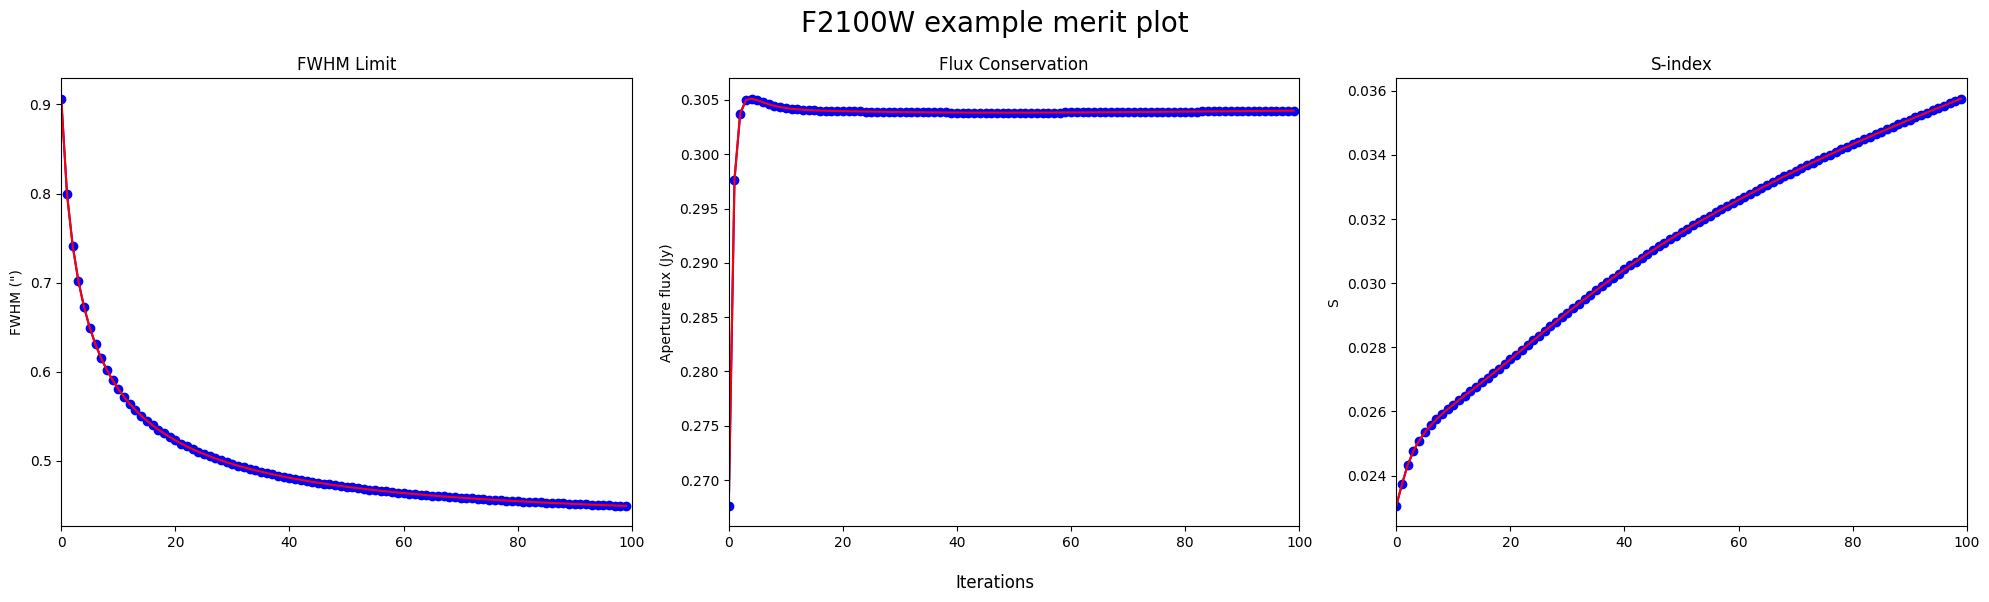

In [73]:
# display and save the merit function plot 
if save_plot_merits:
    # plot the final merit function results
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 6), tight_layout=True)
    ax1.set_title('FWHM Limit')
    ax1.plot(merit_nint, merit_fwhm, marker='o', color='b')
    ax1.plot(merit_nint, merit_fwhm, color='r')
    ax1.set_ylabel('FWHM (")')

    ax2.plot(merit_nint, merit_flux, marker='o', color='b')
    ax2.plot(merit_nint, merit_flux, color='r')
    ax2.set_title('Flux Conservation')
    # NOTE: will need to adjust label if 'convert = False' when 'measure_merits' is called above as the actual units are mJy/sr
    ax2.set_ylabel('Aperture flux (Jy)')

    ax3.plot(merit_nint, merit_smooth, marker='o', color='b')
    ax3.plot(merit_nint, merit_smooth, color='r')
    ax3.set_title('S-index')
    ax3.set_ylabel('S')

    ax1.set_xlim(0, dec_iter)
    ax2.set_xlim(0, dec_iter)
    ax3.set_xlim(0, dec_iter)

    fig.supxlabel('Iterations')
    fig.suptitle(filter + ' example merit plot', fontsize=20)
    plt.savefig(path + filter + '_metrics_plot.pdf')
    plt.show()

In [74]:
# save the final deconvolved image to a FITS file
if save_final_FITS:
    # Save the final image data
    dec_img_data = final_fits[0]

    # save the intial emrits to 5 decimal places
    obs_fwhm = '%.5f' % initial_fwhm
    obs_flux = '%.5f' % initial_flux
    obs_S = '%.5f' % initial_S

    # save the final input image
    obs_name = filter + '_final_original_image_ex.fits'
    sci_hdr['FILTER'] = (filter, 'Observation filter')
    sci_hdr['FWHM'] = (float(obs_fwhm), 'Observed image FWHM (")')
    sci_hdr['FLUX'] = (float(obs_flux), 'Observed image aperture flux(Jy)')
    sci_hdr['S-INDEX'] = (float(obs_S), 'Observed image smoothness index')
    fits.writeto(path + obs_name, image_data, sci_hdr, overwrite=True)

    # save the final deconvolved image
    sci_hdr['FILTER'] = (filter, 'Observation filter')
    sci_hdr['METHOD'] = ('Richardson-Lucy', 'Deconvolution method used')
    sci_hdr['CONITER'] = (int(final_iter), 'Iteration number image converged at')
    sci_hdr['FWHM'] = (float(final_fwhm), 'Converged image FWHM (")')
    sci_hdr['FLUX'] = (float(final_flux), 'Converged image aperture flux(Jy)')
    sci_hdr['S-INDEX'] = (float(final_S), 'Converged image smoothness index')
    dec_name = filter + '_final_deconvolved_image_ex.fits'
    fits.writeto(path + dec_name, dec_img_data, sci_hdr, overwrite=True)

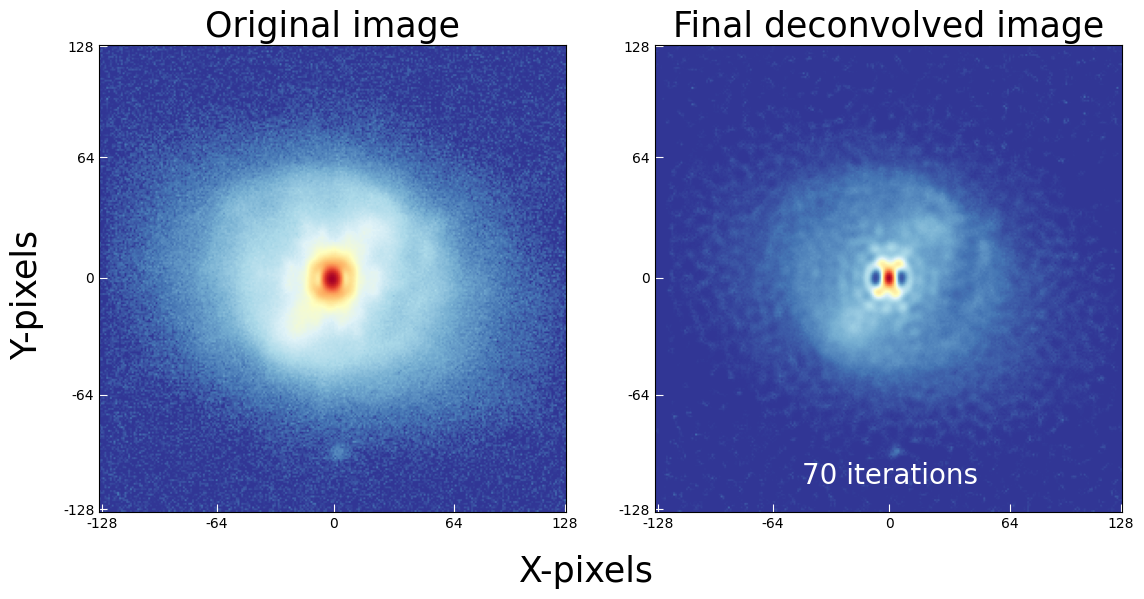

In [76]:
# Plot a side-by-side comparison of the original and nth-deconvolved image
if save_plot_comparison:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), tight_layout=True)
    # plot the original image
    ax[0].imshow(image_data, origin = 'lower', norm = ImageNormalize(stretch=LogStretch(), vmin=0, vmax=image_data.max()), cmap = 'RdYlBu_r')
    ax[0].set_title('Original image', fontsize=25)
    # plot the deconvolved image
    ax[1].imshow(dec_img_data, origin = 'lower', norm = ImageNormalize(stretch=LogStretch(), vmin=0, vmax=dec_img_data.max()), cmap = 'RdYlBu_r')
    ax[1].set_title('Final deconvolved image', fontsize=25)
    ax[1].text(80,15,str(final_iter) + ' iterations', color = 'w', fontsize=20)

    # set the plot params
    ax[0].tick_params(direction='in', color='w', length=6, left=True, top=False, right=False, bottom=True, labelleft=True, labeltop=False, labelright=False, labelbottom=True)
    ax[1].tick_params(direction='in', color='w', length=6, left=True, top=False, right=False, bottom=True, labelleft=True, labeltop=False, labelright=False, labelbottom=True)

    # set the RA/DEC labels-x axis
    labels = ['-128', '-64', '0', '64', '128']
    positions = [1, 64, 128, 194, 255]      
    ax[0].xaxis.set_major_locator(ticker.FixedLocator(positions))
    ax[0].xaxis.set_major_formatter(ticker.FixedFormatter(labels))
    ax[1].xaxis.set_major_locator(ticker.FixedLocator(positions))
    ax[1].xaxis.set_major_formatter(ticker.FixedFormatter(labels))
    ax[0].yaxis.set_major_locator(ticker.FixedLocator(positions))
    ax[0].yaxis.set_major_formatter(ticker.FixedFormatter(labels))
    ax[1].yaxis.set_major_locator(ticker.FixedLocator(positions))
    ax[1].yaxis.set_major_formatter(ticker.FixedFormatter(labels))


    # set the x/y labels
    fig.supylabel('Y-pixels', fontsize=25)
    fig.supxlabel('X-pixels', fontsize=25)
    fig.subplots_adjust(hspace=0, wspace=0)
    plt.savefig(path + filter + '_image_comparison.pdf')
    plt.show()